In [48]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [45]:
dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
dataset_info

test_set, training_set, validation_set = dataset['test'], dataset['train'], dataset['validation']

In [3]:
num_training_examples = 0
num_validation_examples = 0
num_test_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

for example in test_set:
  num_test_examples += 1

print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {}'.format(num_validation_examples))
print('Total Number of Test Images: {} \n'.format(num_test_examples))

num_classes = dataset_info.features['label'].num_classes
print('Total Number of Classes: {}'.format(num_classes))

Total Number of Training Images: 1020
Total Number of Validation Images: 1020
Total Number of Test Images: 6149 

Total Number of Classes: 102


In [60]:
for i, example in enumerate(training_set.take(3)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (500, 667, 3) label: 72
Image 2 shape: (500, 666, 3) label: 84
Image 3 shape: (670, 500, 3) label: 70


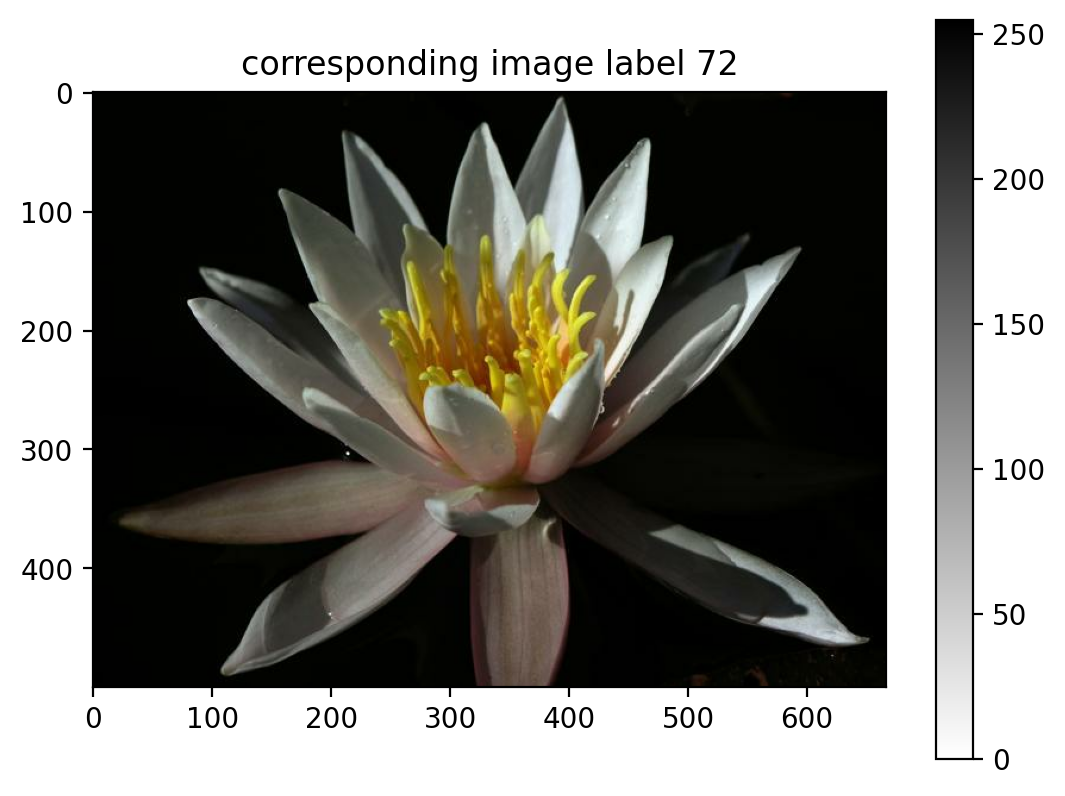

In [61]:
for image, label in training_set.take(1):
  break
image = image.numpy()
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('corresponding image label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

In [6]:
!unzip archive.zip

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [7]:
!unziparchive.zip > /dev/null

/bin/bash: line 1: unziparchive.zip: command not found


In [8]:
import json

with open('/content/cat_to_name.json', 'r') as f:
    class_names = json.load(f)

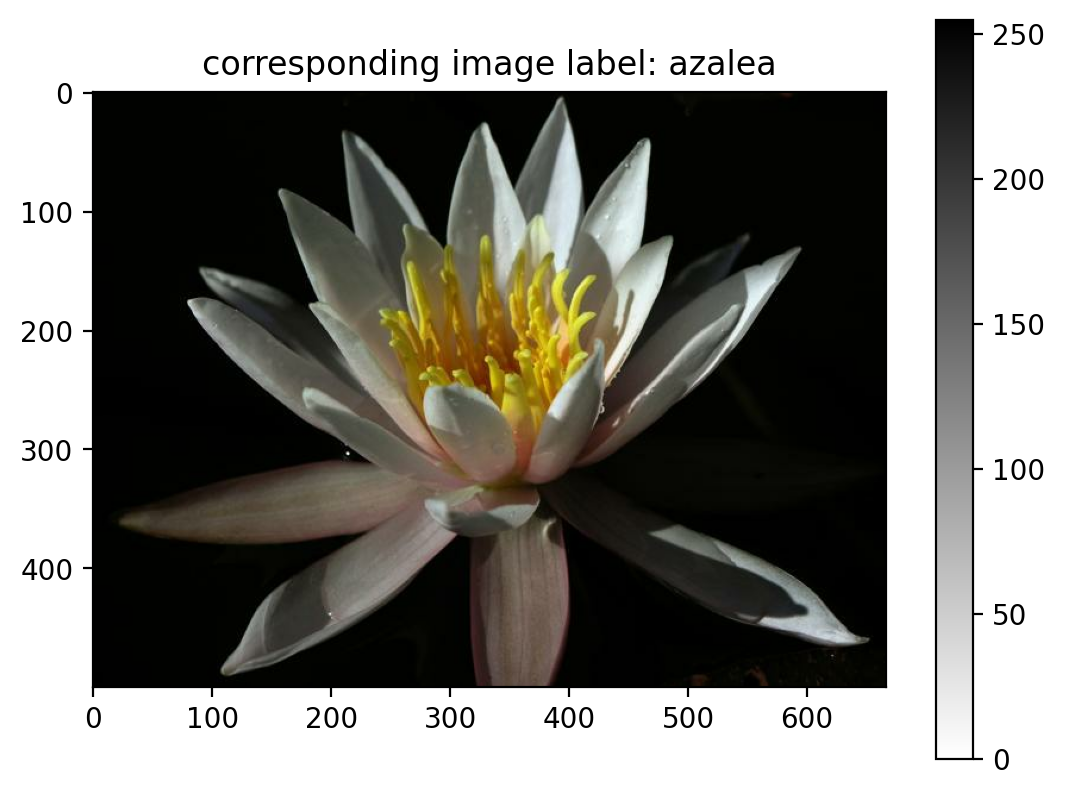

In [9]:
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('corresponding image label: {}'.format(class_names[str(label.numpy())]))
plt.colorbar()
plt.grid(False)
plt.show()

In [10]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.cache().shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = test_set.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

In [11]:
from tensorflow.keras import layers

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

feature_extractor.trainable = False

model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2388646 (9.11 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [12]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 20

# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/20
32/32 [==============================] - 17s 157ms/step - loss: 4.2922 - accuracy: 0.1049 - val_loss: 3.1144 - val_accuracy: 0.3686
Epoch 2/20
32/32 [==============================] - 2s 75ms/step - loss: 2.0835 - accuracy: 0.6912 - val_loss: 2.0213 - val_accuracy: 0.6480
Epoch 3/20
32/32 [==============================] - 2s 77ms/step - loss: 1.1144 - accuracy: 0.8922 - val_loss: 1.5385 - val_accuracy: 0.7206
Epoch 4/20
32/32 [==============================] - 2s 69ms/step - loss: 0.6710 - accuracy: 0.9647 - val_loss: 1.3035 - val_accuracy: 0.7588
Epoch 5/20
32/32 [==============================] - 2s 69ms/step - loss: 0.4455 - accuracy: 0.9853 - val_loss: 1.1621 - val_accuracy: 0.7765
Epoch 6/20
32/32 [==============================] - 2s 70ms/step - loss: 0.3171 - accuracy: 0.9931 - val_loss: 1.0731 - val_accuracy: 0.7941
Epoch 7/20
32/32 [==============================] - 2s 76ms/step - loss: 0.2381 - accuracy: 1.0000 - val_loss: 1.0124 - val_accuracy: 0.7961
Epoch 8/20


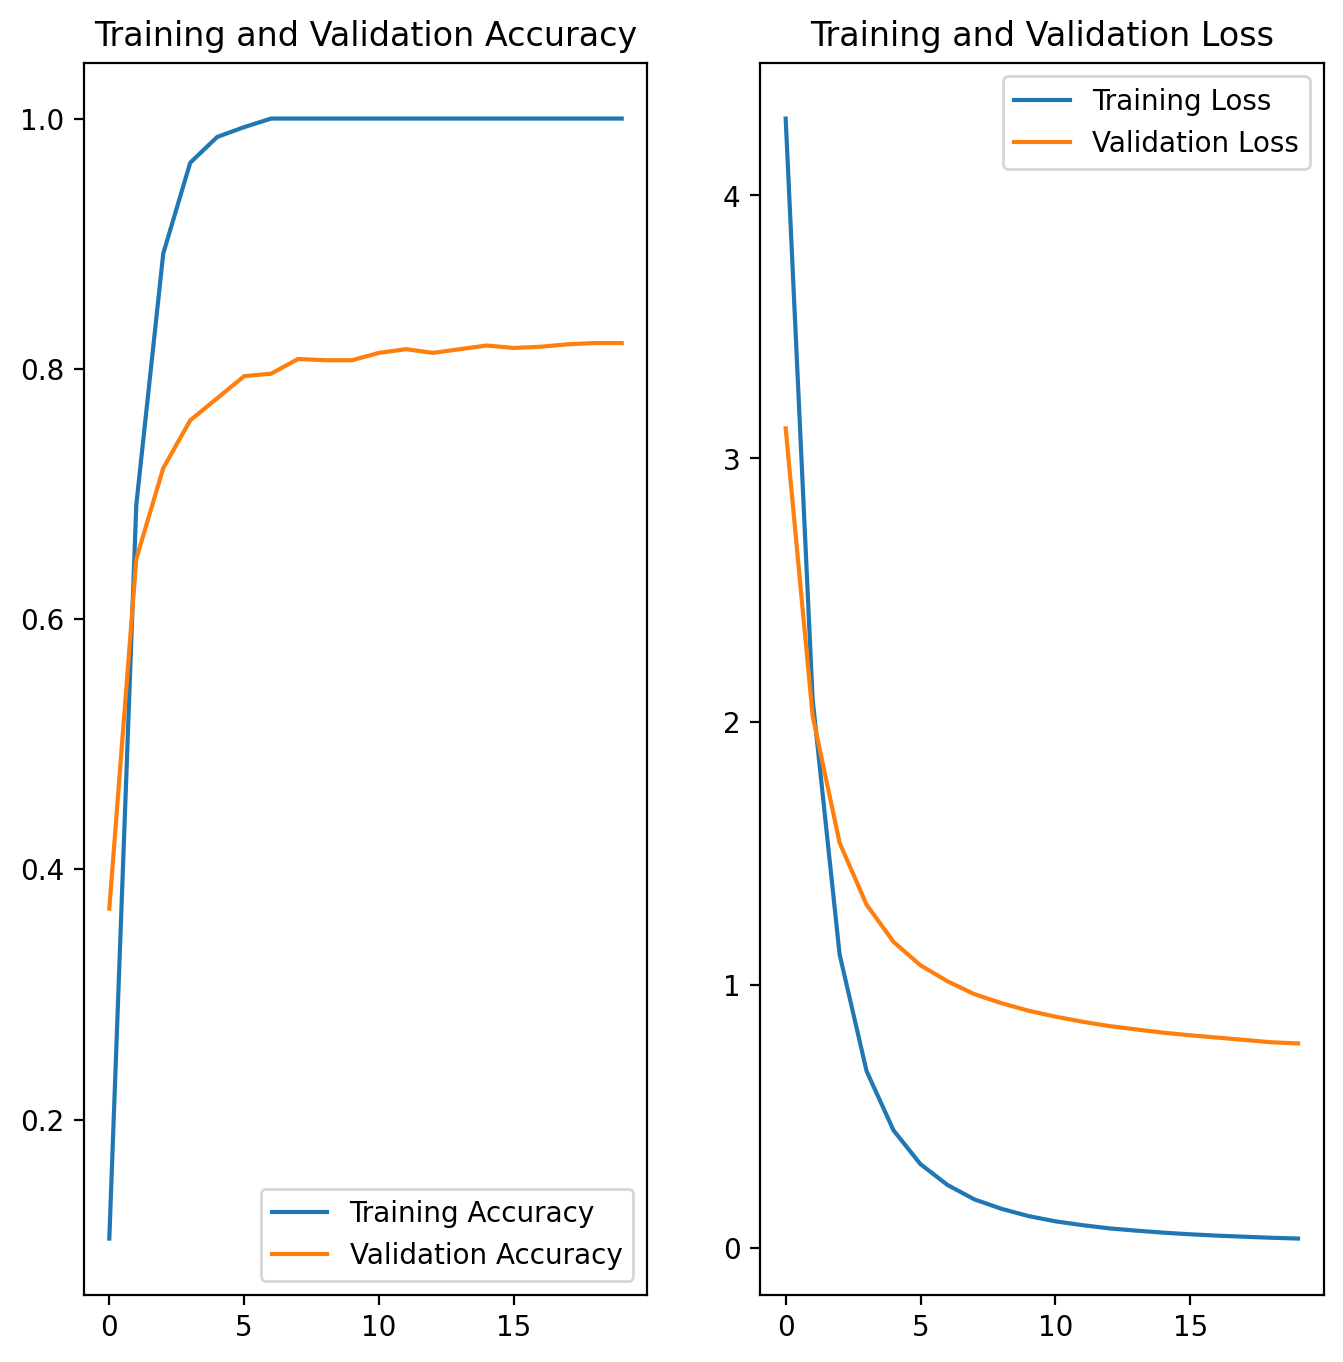

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
#import time
#t = time.time()

#export_path_keras = "./{}.h5".format(int(t))
#print(export_path_keras)

#model.save(export_path_keras)

In [17]:
model.save('flower_model.h5')

In [62]:
probs, classes = model.predict(image_path, model, 5)

NameError: ignored

In [63]:
def process_image(img):
    image = np.squeeze(img)
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image

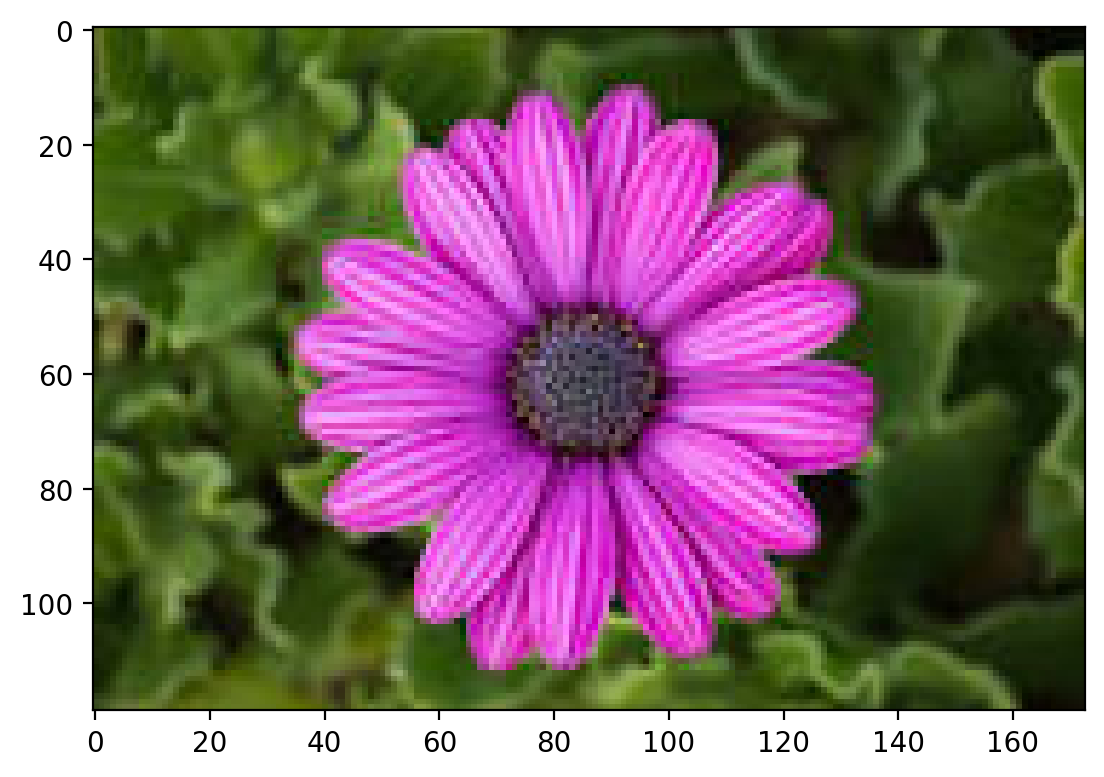

In [88]:
from PIL import Image

image_path = '/content/flower.jpeg'
im = Image.open(image_path)
test_image = np.asarray(im)


plt.imshow(test_image)


In [89]:
def predict(image_path, model, top_k):
    im = Image.open(image_path)
    test_image = np.asarray(im)
    prediction = model.predict(np.expand_dims(processed_test_image, axis=0))
    top_values, top_indices = tf.math.top_k(prediction, top_k)
    print("These are the top propabilities",top_values.numpy()[0])
    top_classes = [class_names[str(value)] for value in top_indices.cpu().numpy()[0]]
    print('Of these top classes', top_classes)
    return top_values.numpy()[0], top_classes

In [90]:
import glob
files = glob.glob('../input/test-images/*.jpg')
for image_path in files:
    im = Image.open(image_path)
    test_image = np.asarray(im)
    probs, classes = predict(image_path, model, 5)
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
    ax1.imshow(test_image)
    ax2 = plt.barh(classes[::-1], probs[::-1])
    plt.tight_layout()
    plt.show()